In [17]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [18]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224, 
                width=224,
                p=0.5,
            ),
            Resize(
                width=224,
                height=224,
            )
        ])
    return Compose([
        Resize(
            width=224, 
            height=224
        )
    ])

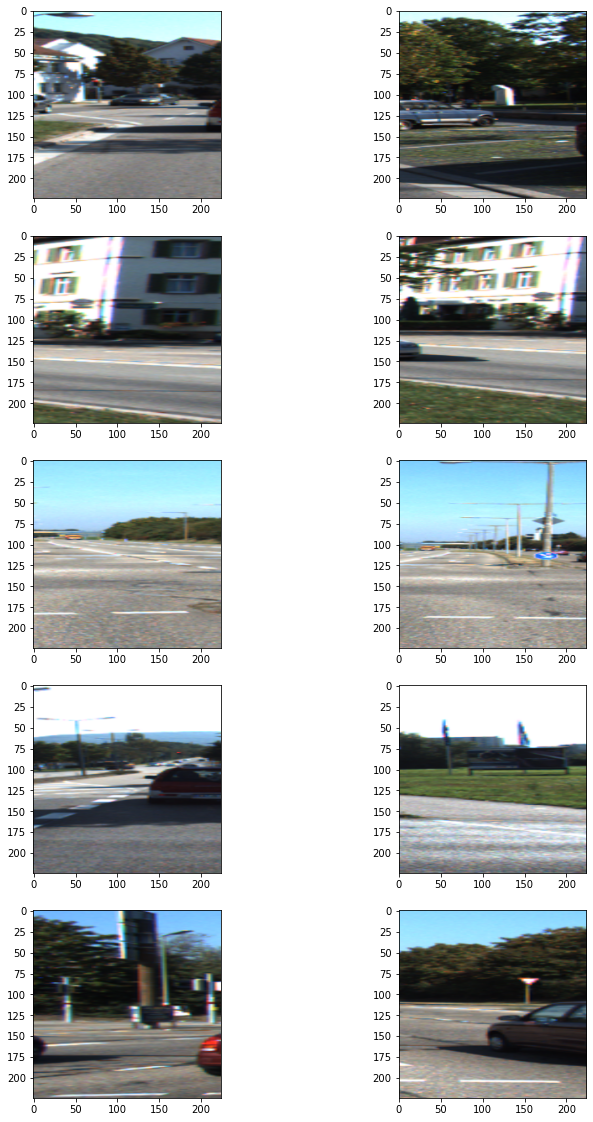

In [19]:
dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])
    
plt.show()

In [20]:
class KittiGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, dir_path, batch_size=16, img_size=(224, 224, 3), output_size=(224, 224), is_train=True, augmentation=None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        self.data = self.load_dataset()
        
    def load_dataset(self):
        
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        
        batch_data = self.data[index*self.batch_size : (index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            return inputs, outputs
        
    def on_epoch_end(self):
        
    
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [21]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path, augmentation=augmentation)

test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

In [22]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7  = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, outputs=conv10)
    
    return model

In [23]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
    generator=train_generator, 
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100, 
)

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)

Epoch 1/100
11/11 [==============================] - 6s 539ms/step - loss: 0.6888 - val_loss: 0.6691
Epoch 2/100
11/11 [==============================] - 6s 538ms/step - loss: 0.3897 - val_loss: 0.0460
Epoch 3/100
11/11 [==============================] - 6s 525ms/step - loss: 0.0407 - val_loss: 0.0426
Epoch 4/100
11/11 [==============================] - 6s 552ms/step - loss: 0.0389 - val_loss: 0.0365
Epoch 5/100
11/11 [==============================] - 6s 556ms/step - loss: 0.0301 - val_loss: 0.0302
Epoch 6/100
11/11 [==============================] - 6s 534ms/step - loss: 0.0275 - val_loss: 0.0386
Epoch 7/100
11/11 [==============================] - 6s 532ms/step - loss: 0.0319 - val_loss: 0.0342
Epoch 8/100
11/11 [==============================] - 6s 535ms/step - loss: 0.0373 - val_loss: 0.0399
Epoch 9/100
11/11 [==============================] - 6s 535ms/step - loss: 0.0352 - val_loss: 0.0293
Epoch 10/100
11/11 [==============================] - 6s 537ms/step - loss: 0.0332 - val_lo

11/11 [==============================] - 6s 537ms/step - loss: 0.0078 - val_loss: 0.0191
Epoch 80/100
11/11 [==============================] - 6s 537ms/step - loss: 0.0092 - val_loss: 0.0200
Epoch 81/100
11/11 [==============================] - 6s 545ms/step - loss: 0.0087 - val_loss: 0.0152
Epoch 82/100
11/11 [==============================] - 6s 545ms/step - loss: 0.0102 - val_loss: 0.0158
Epoch 83/100
11/11 [==============================] - 6s 541ms/step - loss: 0.0074 - val_loss: 0.0155
Epoch 84/100
11/11 [==============================] - 6s 575ms/step - loss: 0.0140 - val_loss: 0.0171
Epoch 85/100
11/11 [==============================] - 6s 563ms/step - loss: 0.0091 - val_loss: 0.0164
Epoch 86/100
11/11 [==============================] - 6s 565ms/step - loss: 0.0146 - val_loss: 0.0187
Epoch 87/100
11/11 [==============================] - 6s 552ms/step - loss: 0.0128 - val_loss: 0.0170
Epoch 88/100
11/11 [==============================] - 6s 579ms/step - loss: 0.0079 - val_loss: 

In [31]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU :%f' % iou_score)
    return iou_score

In [32]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

IoU :0.883564


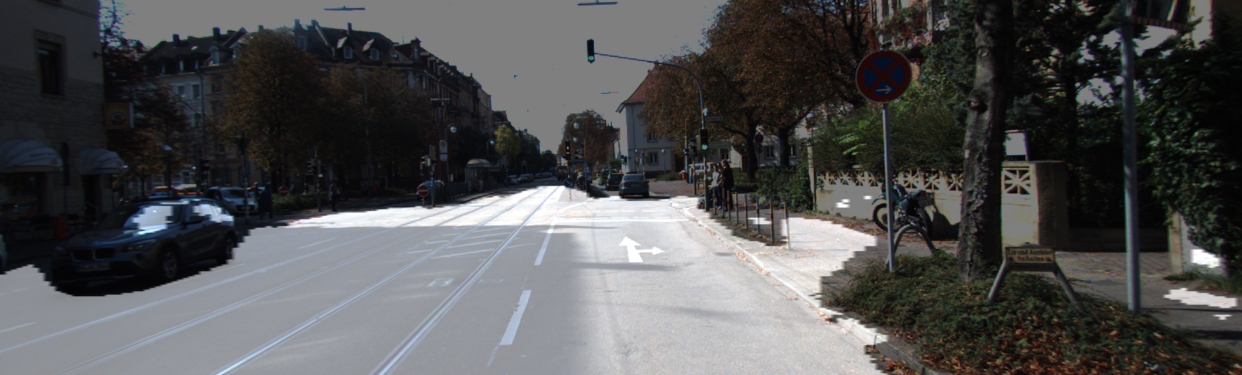

In [33]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

output